# 1 - Imports

In [1]:
import pandas as pd
import inflection
import calendar
import datetime
import random
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import Image
from tabulate import tabulate
from pycorrcat.pycorrcat import corr_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from warnings import filterwarnings

In [2]:
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option( 'display.expand_frame_repr', False )

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 8]

sns.set;

## 1.2 - Funções

In [3]:
# Gráfico kde
def kde(var, data):
    '''Função para criar gráfico de kde
    var: Variável
    data: dataframe'''
    aux = data.sort_values(var)
    aux = aux[var].unique()
    for e in aux:
        sns.kdeplot(data[data[var] == e]['sales'], label=e, shade=True)
    plt.ticklabel_format(style='plain', axis='y')
    plt.legend()
    
    return None


def ml_error(model_name, y_test, y_pred):
    '''Avaliação do modelo de regressão
    model_name: Nome do modelo
    y_test: y teste
    y_pred: y predito'''
    mae = np.round(mean_absolute_error(y_test, y_pred), 2)
    mape = np.round(mean_absolute_percentage_error(y_test, y_pred) * 100, 2)
    rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
    data = {'model_name': model_name, 'MAE':mae, 'MAPE':mape, 'RMSE':rmse}
    df = pd.DataFrame(data, index=[0])
    
    return df


def cross_validation(modelo, model_name, df_full, k_fold, verbose=False):
    '''Função para Cross Validation com split de Série Temporal
    modelo: modelo utilizado
    nome_modelo: nome do modelo
    df_full: dataframe completo
    k_fold: Quantidade de vezes que o modelo irá fazer o split com o treino e validação
    verbose: Mostrar o fold atual (default=False)'''
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in range(1, k_fold+1):
        if verbose:
            print(k)

        # Data inicial e final para validação
        validation_start_date = df_full['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = df_full['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtrando o dataset
        training = df_full[df_full['date'] < validation_start_date]
        validation = df_full[(df_full['date'] >= validation_start_date) & (df_full['date'] <= validation_end_date)]

        # Dataset de treino e validação
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Modelo
        model = modelo.fit(xtraining, ytraining)

        # Predição
        y_pred_model = model.predict(xvalidation)

        # Perfomance
        resultado = ml_error('Linear Regression Model', yvalidation ** 3, y_pred_model ** 3)
        mae_list.append(resultado['MAE'])
        mape_list.append(resultado['MAPE'])
        rmse_list.append(resultado['RMSE'])
        
    # Resultado
    mean_mae = np.round(np.mean(mae_list),2)
    mean_mape = np.round(np.mean(mape_list),2)
    mean_rmse = np.round(np.mean(rmse_list),2)
    std_mae = np.round(np.std(mae_list),2)
    std_mape = np.round(np.std(mape_list),2)
    std_rmse = np.round(np.std(rmse_list),2)
    mae = 'mean: ' + mean_mae.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_mae.astype(str)
    mape = 'mean: ' + mean_mape.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_mape.astype(str)
    rmse = 'mean: ' + mean_rmse.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_rmse.astype(str)
    data = {'model_name': model_name, 'MAE CV':mae, 'MAPE CV':mape, 'RMSE CV':rmse}
    df = pd.DataFrame(data, index=[0])
    
    return df

## 1.3 - Carregando os dados

In [4]:
df_train = pd.read_csv('dados/train.csv', low_memory=False)
print(f'shape do dataset train: {df_train.shape}')

df_store = pd.read_csv('dados/store.csv', low_memory=False)
print(f'shape do dataset store: {df_store.shape}')

# Unir os datasets
df = pd.merge(df_train, df_store, how='left', on='Store')

shape do dataset train: (1017209, 9)
shape do dataset store: (1115, 10)


In [5]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 2 - Descrição dos dados

In [6]:
df2 = df.copy()

## 2.1 - Dimensão do dataset

In [7]:
print(f'Quantidade de linhas: {df2.shape[0]}')
print(f'Quantidade de colunas: {df2.shape[1]}')

Quantidade de linhas: 1017209
Quantidade de colunas: 18


## 2.2 - Renomear as colunas

In [8]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x:inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

df2.columns = new_cols

## 2.3 - Tipo dos dados

In [9]:
df2['date'] = pd.to_datetime(df2['date'])

df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 - Dados nulos

In [10]:
df2.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5 - Correção dados nulos

In [11]:
# competition_distance
df2['competition_distance'].fillna(200000, inplace=True)

# competition_open_since_month
df2['competition_open_since_month'].fillna(df2['date'].dt.month, inplace=True)

# competition_open_since_year
df2['competition_open_since_year'].fillna(df2['date'].dt.year, inplace=True)

# promo2_since_week
df2['promo2_since_week'].fillna(df2['date'].dt.week, inplace=True)

# promo2_since_year
df2['promo2_since_year'].fillna(df2['date'].dt.year, inplace=True)

# promo_interval
df2['promo_interval'].fillna(0, inplace=True)

month_map = dict(enumerate(calendar.month_abbr))

df2['month_map'] = df2['date'].dt.month.map(month_map)

df2['is_promo'] = df2[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
df2.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.6 - Alteração dos tipos dos dados

In [13]:
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
df2['promo2_since_week'] = df2['promo2_since_week'].astype(int)
df2['promo2_since_year'] = df2['promo2_since_year'].astype(int)

In [14]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.7 - Análise descritiva

In [15]:
num = df2.select_dtypes(include=['int64', 'float64'])
cat = df2.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1 - Análise numérica

In [16]:
# média, desvio padrão, mínimo, quartis, máximo
desc = num.describe().T
desc.drop('count', axis=1, inplace=True)

# mediana
median = pd.DataFrame(num.apply(np.median))
desc.insert(2,'median', median[0].values)

# range
range_ = pd.DataFrame( num.apply( lambda x: x.max() - x.min() ) )
desc.insert(len(desc.columns),'range', range_[0].values)

# trocando o desvio padrão de posição
std = desc.pop('std')
desc.insert(len(desc.columns),'std', std)

# skewness
skew = pd.DataFrame(num.apply(lambda x: x.skew()))
desc.insert(len(desc.columns),'skew', skew[0].values)

# kurtosis
kurtosis = pd.DataFrame(num.apply(lambda x: x.kurtosis()))
desc.insert(len(desc.columns),'kurtosis', kurtosis[0].values)

desc

,mean,median,min,25%,50%,75%,max,range,std,skew,kurtosis
store,558.429727,558.0,1.0,280.0,558.0,838.0,1115.0,1114.0,321.908651,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.0,2.0,4.0,6.0,7.0,6.0,1.997391,0.001593,-1.246873
sales,5773.818972,5744.0,0.0,3727.0,5744.0,7856.0,41551.0,41551.0,3849.926175,0.641460,1.778375
customers,633.145946,609.0,0.0,405.0,609.0,837.0,7388.0,7388.0,464.411734,1.598650,7.091773
open,0.830107,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.375539,-1.758045,1.090723
promo,0.381515,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.485759,0.487838,-1.762018
school_holiday,0.178647,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.383056,1.677842,0.815154
competition_distance,5935.442677,2330.0,20.0,710.0,2330.0,6910.0,200000.0,199980.0,12547.652996,10.242344,147.789712
competition_open_since_month,6.786849,7.0,1.0,4.0,7.0,10.0,12.0,11.0,3.311087,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,5.515593,-7.235657,124.071304


### 2.7.2 - Análise categórica

In [17]:
for x in cat.columns:
    print(f'A coluna {x} tem {cat[x].unique().shape[0]} valores únicos: {cat[x].unique()}')

A coluna state_holiday tem 4 valores únicos: ['0' 'a' 'b' 'c']
A coluna store_type tem 4 valores únicos: ['c' 'a' 'd' 'b']
A coluna assortment tem 3 valores únicos: ['a' 'c' 'b']
A coluna promo_interval tem 4 valores únicos: [0 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
A coluna month_map tem 12 valores únicos: ['Jul' 'Jun' 'May' 'Apr' 'Mar' 'Feb' 'Jan' 'Dec' 'Nov' 'Oct' 'Sep' 'Aug']


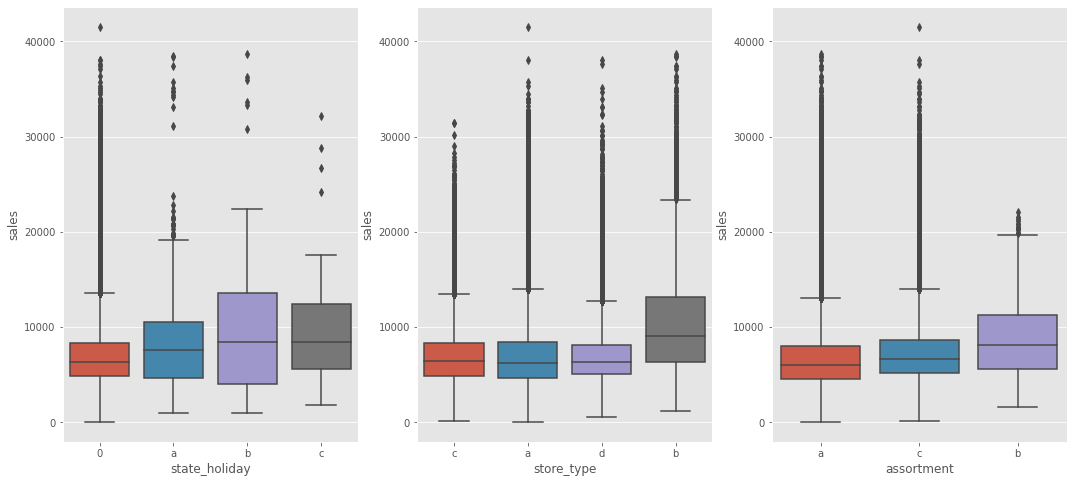

In [18]:
aux = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

### 2.7.3 - Análise temporal

In [19]:
old = df2['date'].min()
new = df2['date'].max()
print(f'A data mais antiga: {old}')
print(f'A data mais atual: {new}')

A data mais antiga: 2013-01-01 00:00:00
A data mais atual: 2015-07-31 00:00:00


# 3 - Feature engineering

In [20]:
df3 = df2.copy()

## 3.1 - Mapa mental das hipóteses

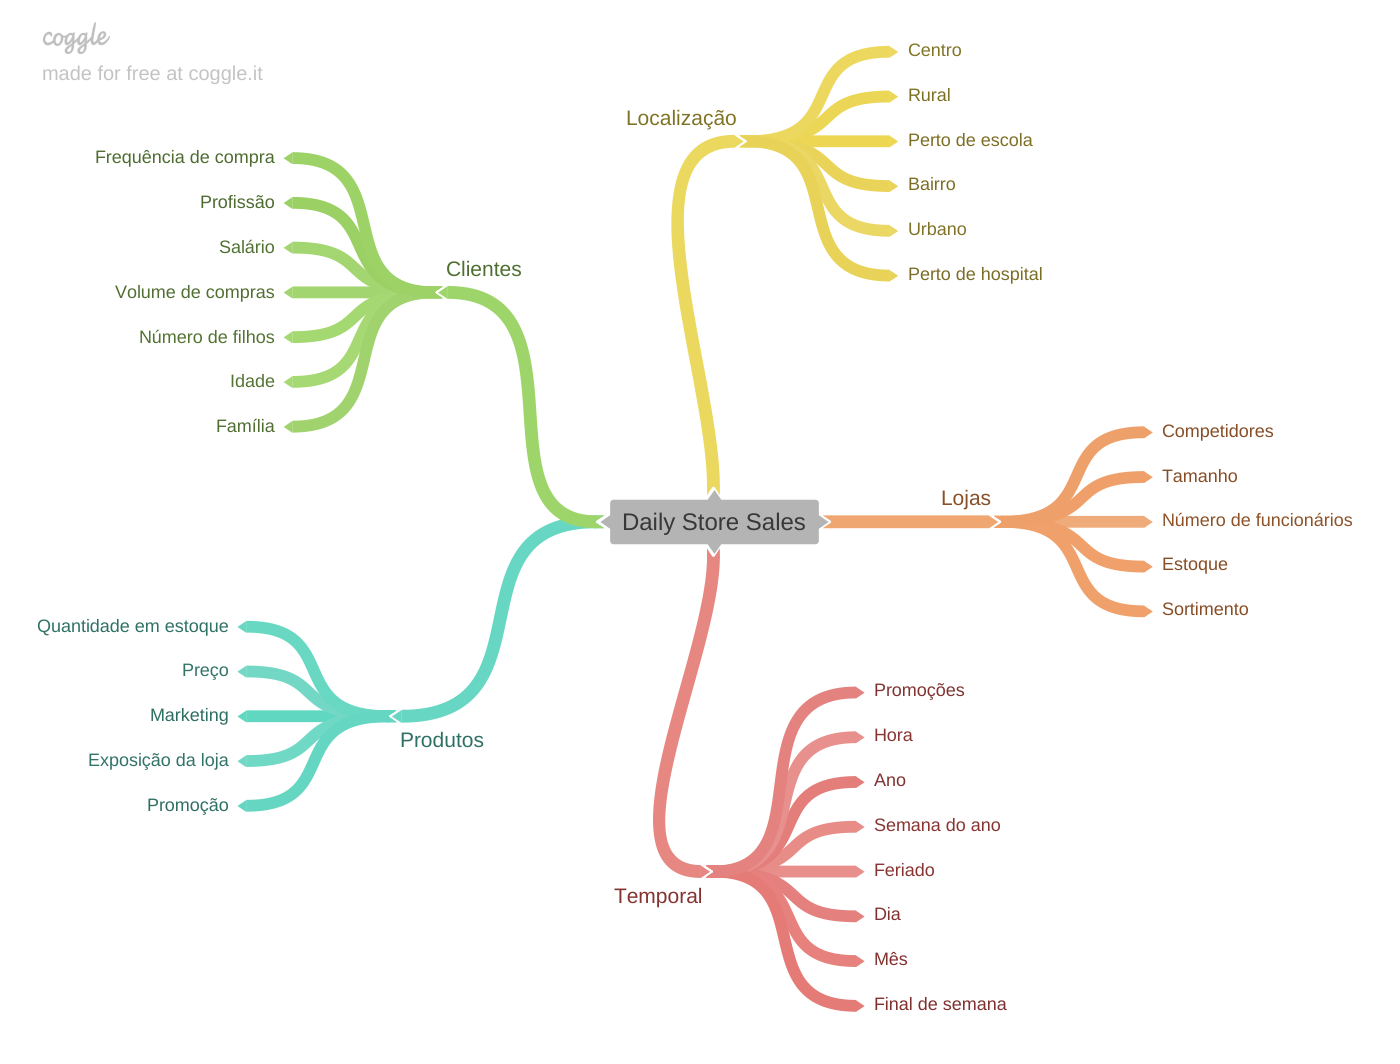

In [21]:
Image('img/hipoteses_mindmap.png', width=650, height=1150)

## 3.2 - Criação das hipóteses

### 3.2.1 - Hipótese da loja

**1.** Loja com maior número de funcionários deveriam vender mais.  
**2.** Lojas com maior capacidade de estoque deveriam vender mais.  
**3.** Lojas com maior porte deveriam vender mais.  
**4.** Lojas com maior sortimentos deveriam vender mais.  
**5.** Lojas com competidores mais próximos deveriam vender menos.  
**6.** Lojas com competidores à mais tempo deveriam vendem mais.  

### 3.2.2 - Hipótese do produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.  
**2.** Lojas com maior exposição de produto deveriam vender mais.  
**3.** Lojas com produtos com preço menor deveriam vender mais.  
**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.  
**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**6.** Lojas com mais dias de promoção deveriam vender mais.  
**7.** Lojas com mais promoções consecutivas deveriam vender mais.  

### 3.2.3 - Hipótese do tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**2.** Lojas deveriam vender mais ao longo dos anos.  
**3.** Lojas deveriam vender mais no segundo semestre do ano.  
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.  
**5.** Lojas deveriam vender menos aos finais de semana.  
**6.** Lojas deveriam vender menos durante os feriados escolares.  

## 3.3 - Lista final de hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.  
**2.** Lojas com competidores mais próximos deveriam vender menos.  
**3.** Lojas com competidores à mais tempo deveriam vendem mais.  
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**5.** Lojas com mais dias de promoção deveriam vender mais.  
**6.** Lojas com mais promoções consecutivas deveriam vender mais.  
**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**8.** Lojas deveriam vender mais ao longo dos anos.  
**9.** Lojas deveriam vender mais no segundo semestre do ano.  
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.  
**11.** Lojas deveriam vender menos aos finais de semana.  
**12.** Lojas deveriam vender menos durante os feriados escolares.  

## 3.4 - Feature engineering

In [22]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# year week
df3['year_week'] = df3['year'].astype(str) + '-' + df3['week_of_year'].apply(lambda x: '{0:0>2}'.format(x)).astype(str)

# competition since
df3['competition_since'] = df3.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# competition_time_month
df3['competition_time_month'] = ((df3['date'] - df3['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df3['promo_time_week'] = ((df3['date'] - df3['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-31,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-31,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-31,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-31,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-31,2015-04-01,4,2015-07-27,0


# 4 - Filtragem das variáveis

In [24]:
df4 = df3.copy()

## 4.1 - Seleção das linhas

In [25]:
df4 = df4[(df4['open'] !=0) & (df4['sales'] > 0)]

 ## 4.2 - Seleção das colunas

In [26]:
df4.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1, inplace=True)

# 5 - Análise exploratória dos dados

In [27]:
df5 = df4.copy()

## 5.1 - Análise univariada

### 5.1.1 - Variável resposta

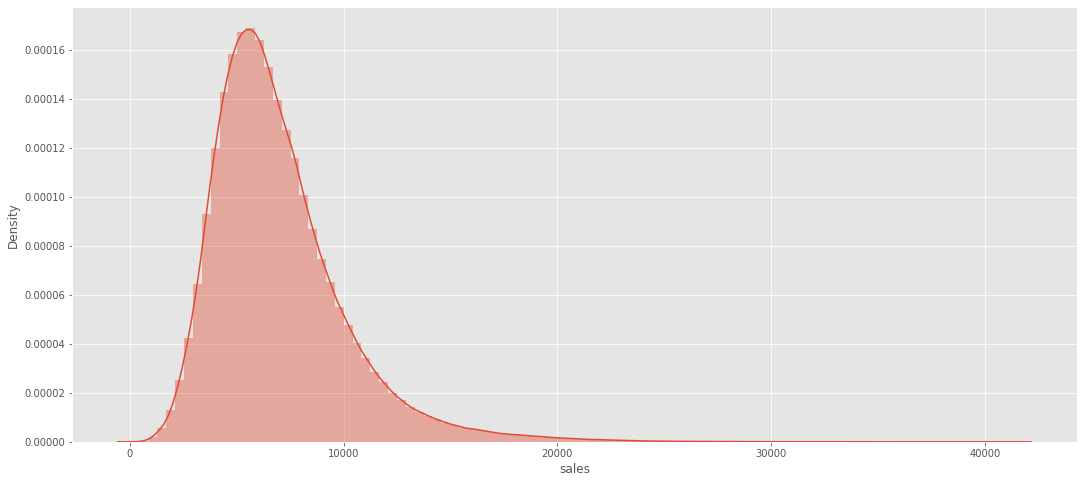

In [28]:
sns.distplot(df5['sales'], bins=100, kde=True);

### 5.1.2 - Variáveis numéricas

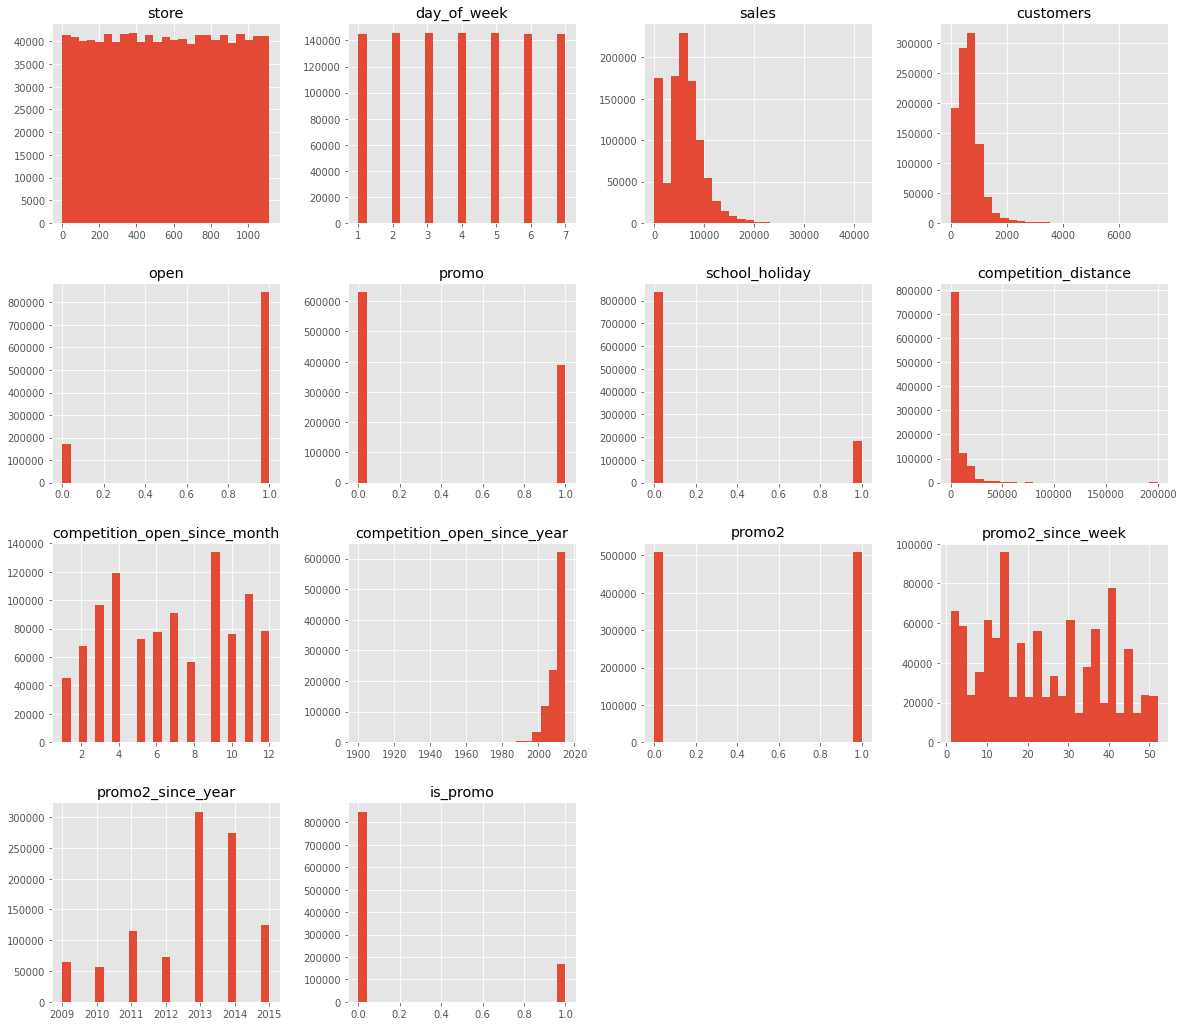

In [29]:
num.hist(figsize=(20,18), bins=25);

### 5.1.3 - Variáveis categóricas

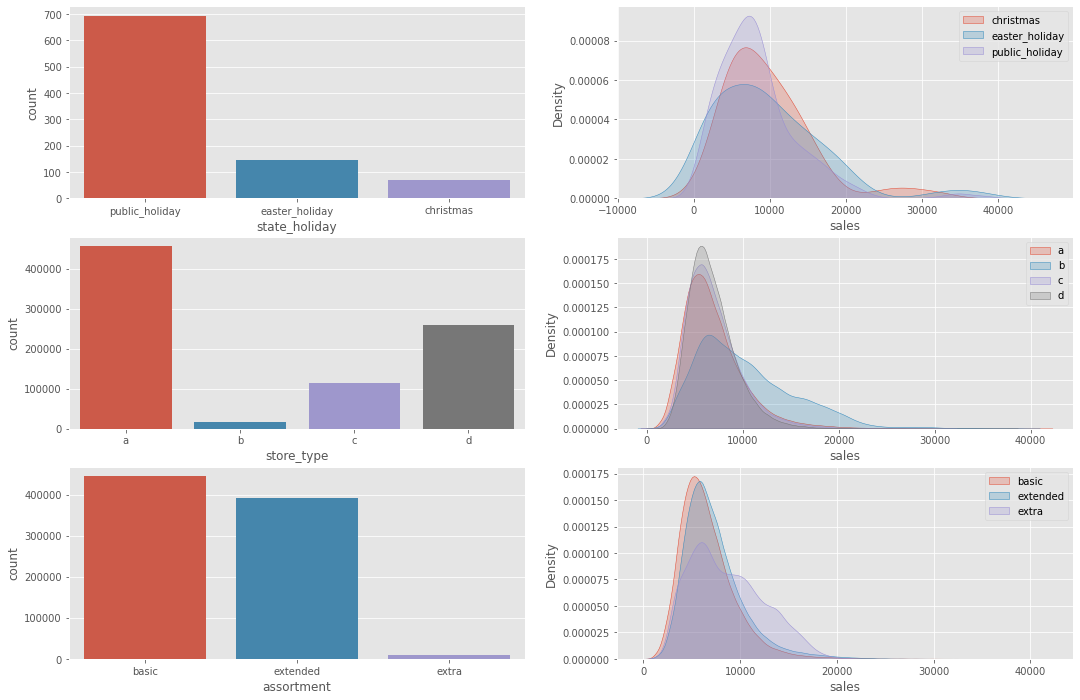

In [30]:
plt.figure(figsize=(18,12))

aux = df5[df5['state_holiday'] != 'regular_day']
    
plt.subplot(3, 2, 1)
sns.countplot(aux['state_holiday'])

plt.subplot(3, 2, 2)
kde('state_holiday', aux)

plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df5.sort_values('store_type'))

plt.subplot(3, 2, 4)
kde('store_type', df5)

plt.subplot(3, 2, 5)
sns.countplot(df5['assortment'])

plt.subplot(3, 2, 6)
kde('assortment', df5);

## 5.2 - Análise bivariada

### Hipótese 1. Lojas com maior sortimentos deveriam vender mais.  
**Verdadeira**, pois na média, as lojas com maior sortimento vendem mais

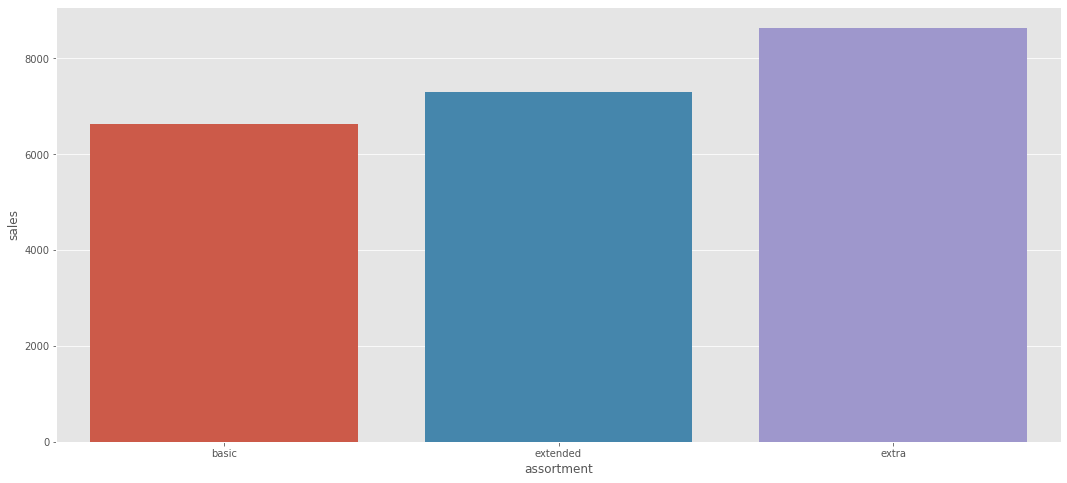

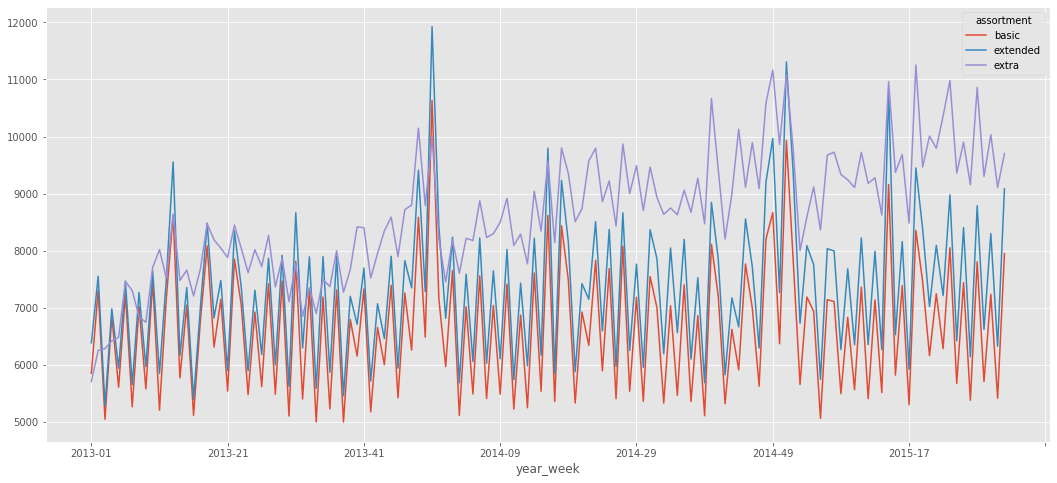

In [31]:
aux = df5.groupby('assortment', as_index=False)['sales'].mean()
sns.barplot(x='assortment', y='sales', data=aux)

aux1 = df5.groupby(['year_week', 'assortment'], as_index=False)['sales'].mean()
aux1.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### Hipótese 2. Lojas com competidores mais próximos deveriam vender menos.  
**Falsa**, pois lojas vendem mais com competidores próximos, na média

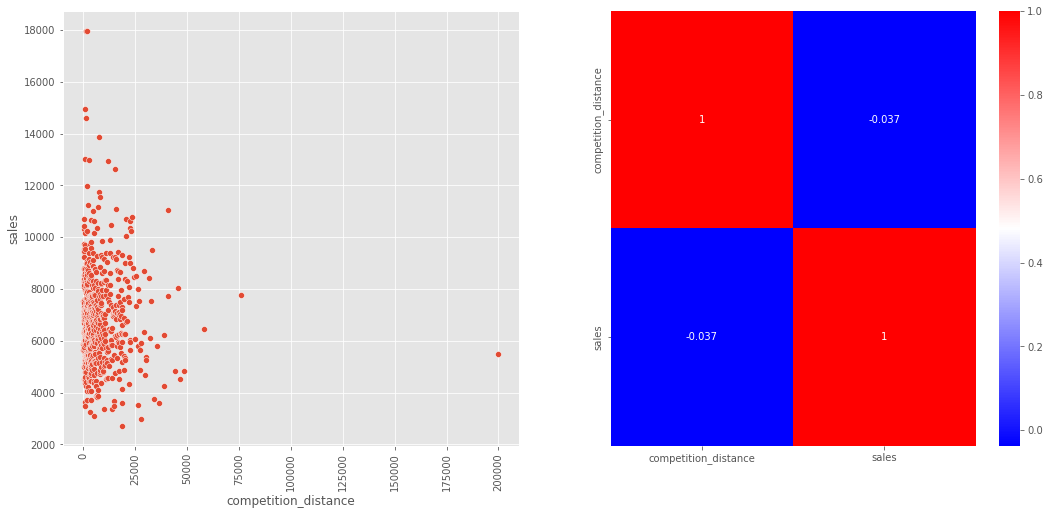

In [32]:
aux = df5.groupby('competition_distance', as_index=False)['sales'].mean()

plt.subplot(1,2,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.heatmap(aux.corr(), annot=True, cmap='bwr');

### hipótese 3. Lojas com competidores à mais tempo deveriam vendem mais.    
**Falsa**, pois lojas vendem mais quando os competidores estão há pouco tempo

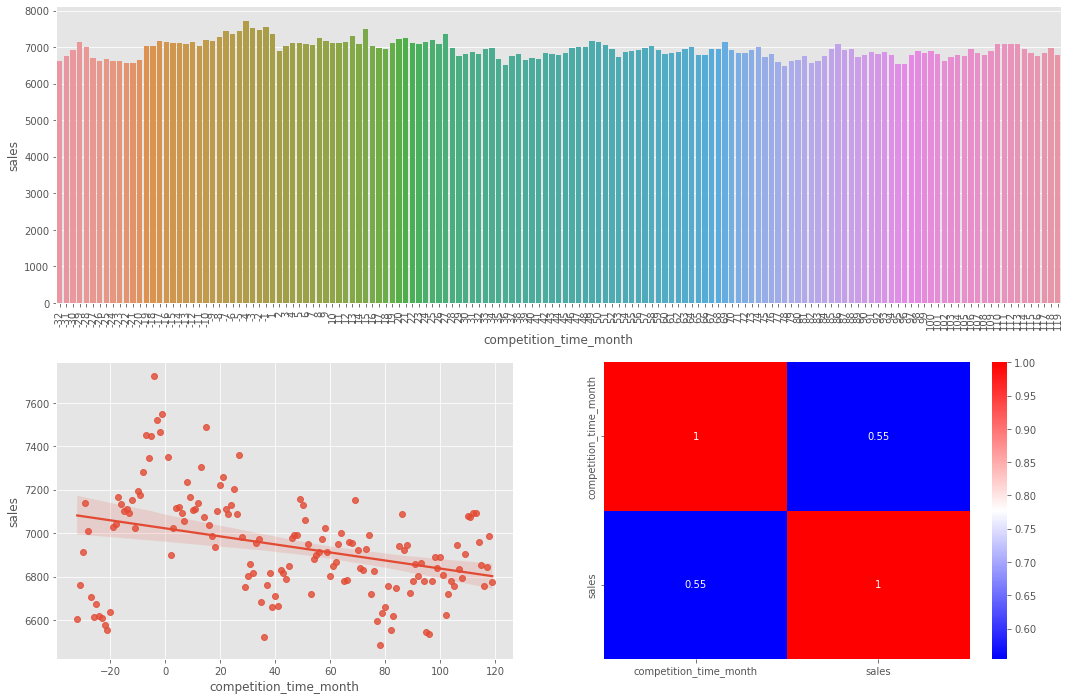

In [33]:
aux = df5.groupby('competition_time_month', as_index=False)['sales'].mean()
aux1 = aux[(aux['competition_time_month'] < 120) & (aux['competition_time_month'] != 0)]

grid = plt.GridSpec(2, 2)
plt.figure(figsize=(18,12))

plt.subplot(grid[0, :])
sns.barplot(x='competition_time_month', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(grid[1, 0])
sns.regplot(x='competition_time_month', y='sales', data=aux1)

plt.subplot(grid[1, 1])
sns.heatmap(aux.corr(), annot=True, cmap='bwr');

 ### hipótese 4. Lojas com promoções ativas por mais tempo deveriam vender mais. 
**Verdadeira**, pois há uma crescente conforme o passar das semanas

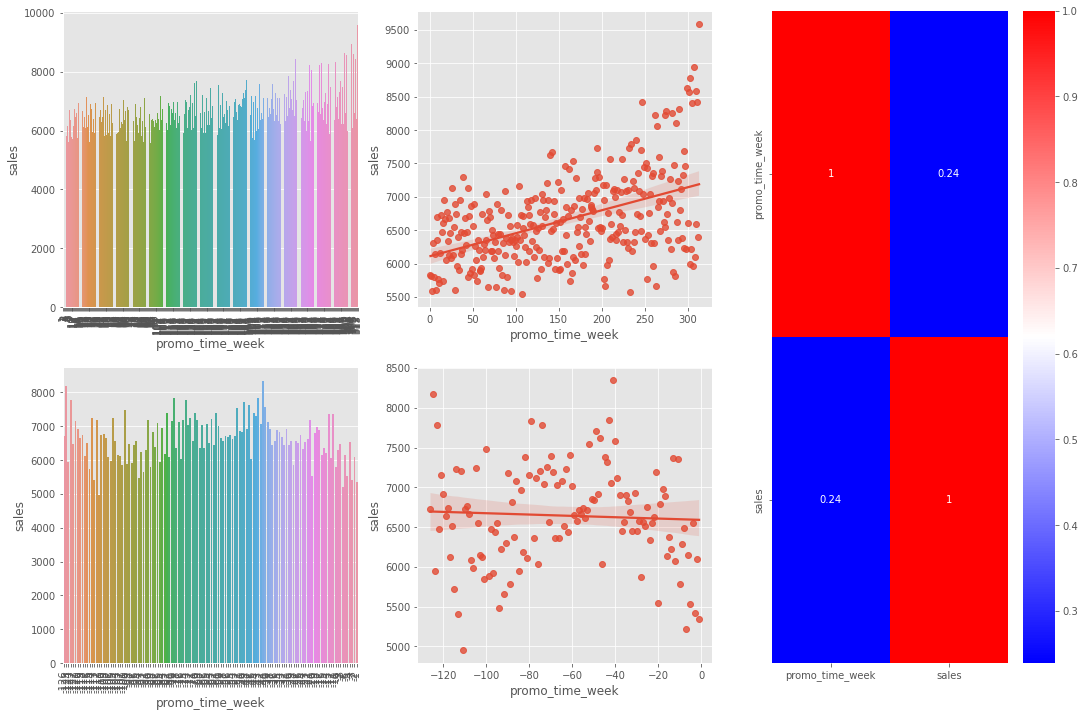

In [34]:
 aux = df5.groupby('promo_time_week', as_index=False)['sales'].mean()
positive_promo = aux[aux['promo_time_week'] > 0]
negative_promo = aux[aux['promo_time_week'] < 0]

grid = plt.GridSpec(2, 3)
plt.figure(figsize=(18,12))

plt.subplot(grid[0, 0])
sns.barplot(x='promo_time_week', y='sales', data=positive_promo)
plt.xticks(rotation=90)

plt.subplot(grid[1, 0])
sns.barplot(x='promo_time_week', y='sales', data=negative_promo)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=positive_promo)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=negative_promo)

plt.subplot(grid[:, 2])
sns.heatmap(aux.corr(), annot=True, cmap='bwr');

### hipótese 5. Lojas com mais promoções consecutivas deveriam vender mais.  
**Falsa**, pois lojas com promoções consecutivas vendem menos que apenas uma promoção

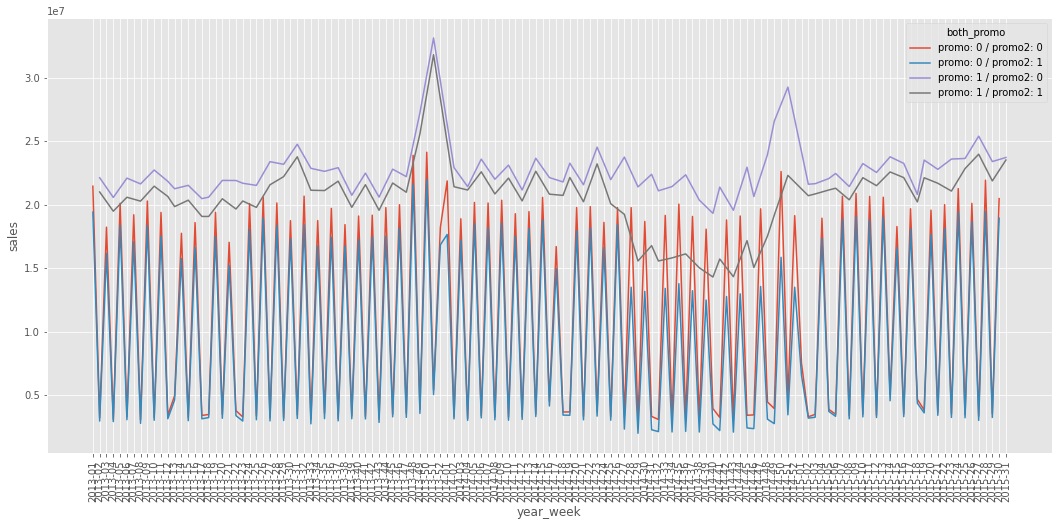

In [35]:
aux = df5.groupby(['promo', 'promo2', 'year_week'], as_index=False)['sales'].sum()
aux['both_promo'] = 'promo: ' + aux['promo'].astype(str) + ' / ' + 'promo2: ' + aux['promo2'].astype(str)
sns.lineplot(x='year_week', y='sales', hue='both_promo', data=aux)
plt.xticks(rotation=90);

### hipótese 6. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa**, pois natal fica levemente abaixo da páscoa no geral.

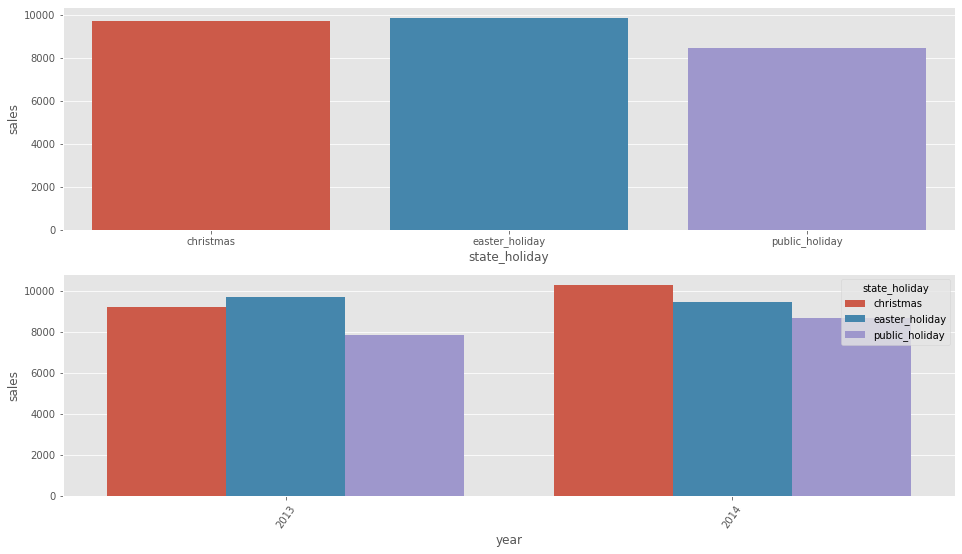

In [36]:
aux = df5[df5['state_holiday'] != 'regular_day']
aux1 = aux.groupby('state_holiday', as_index=False)['sales'].mean()

plt.figure(figsize=(16, 9))

plt.subplot(2, 1, 1)
sns.barplot(x='state_holiday', y='sales', data=aux1)

aux1 = aux.groupby(['year', 'state_holiday'], as_index=False)['sales'].mean()
aux2 = aux1[aux1['year'] < 2015]

plt.subplot(2, 1, 2)
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday')
plt.xticks(rotation=55);

### hipótese 7. Lojas deveriam vender mais ao longo dos anos.  
**Verdadeira**, pois a média mostra uma média crescente, mesmo 2015 não ter o ano fechado

<AxesSubplot:>

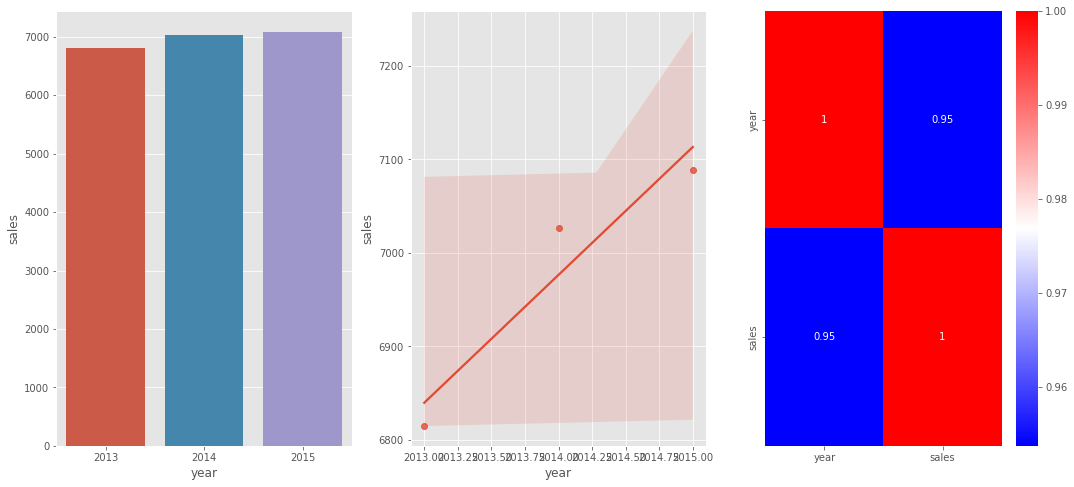

In [37]:
aux = df5.groupby('year', as_index=False)['sales'].mean()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(), annot=True, cmap='bwr')

### hipótese 8. Lojas deveriam vender mais no segundo semestre do ano.  
**Verdadeira**, pois o segundo semestre vendeu 299,55 a mais que o primeiro na média, com destaque nos meses de novembro e dezembro

            semestre        sales
0  primeiro_semestre  6769.396625
1   segundo_semestre  7068.951246


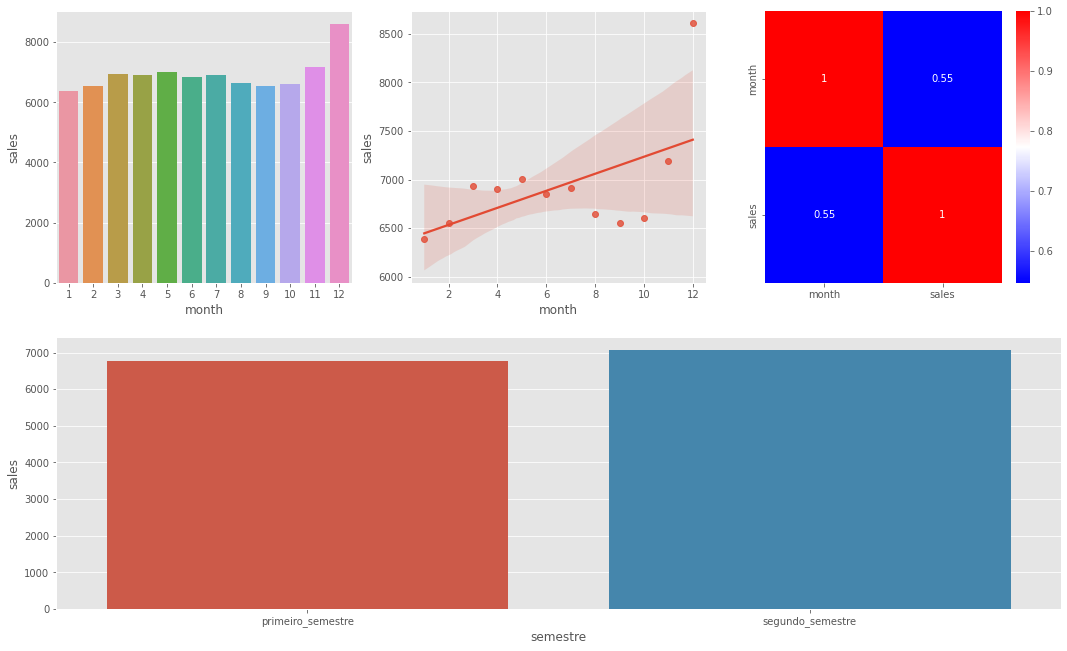

In [38]:
aux = df5[df5['year'] != 2015]
aux['semestre'] = aux['month'].apply(lambda x: 'primeiro_semestre' if x <= 6 else 'segundo_semestre')
aux1 = aux.groupby('month', as_index=False)['sales'].mean()

grid = plt.GridSpec(2, 3)
plt.figure(figsize=(18,11))

plt.subplot(grid[0, 0])
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(grid[0, 1])
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(grid[0, 2])
sns.heatmap(aux1.corr(), annot=True, cmap='bwr')
aux2 = aux.groupby('semestre', as_index=False)['sales'].mean()

plt.subplot(grid[1, :])
sns.barplot(x='semestre', y='sales', data=aux2)
print(aux2);

In [39]:
 aux2['sales'][1] - aux2['sales'][0]

299.55462141413227

### hipótese 9. Lojas deveriam vender mais depois do dia 10 de cada mês.  
**Falsa**, pois na média, as lojas vendem mais até o dia 10

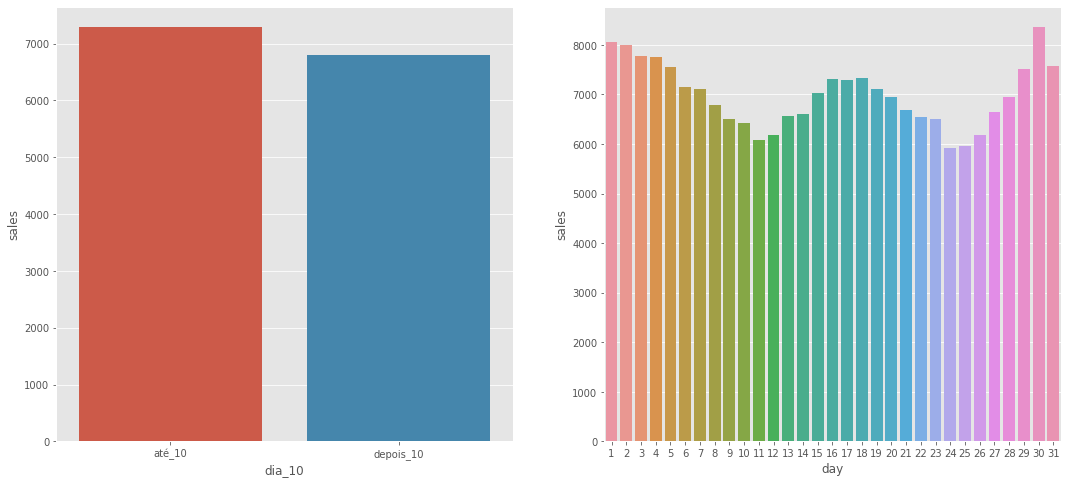

In [40]:
aux = df5.copy()
aux['dia_10'] = aux['day'].apply(lambda x: 'até_10' if x <= 10 else 'depois_10')
aux1 = aux.groupby('dia_10', as_index=False)['sales'].mean()

plt.subplot(1, 2, 1)
sns.barplot(x='dia_10', y='sales', data=aux1)

aux2 = aux.groupby('day', as_index=False)['sales'].mean()

plt.subplot(1, 2, 2)
sns.barplot(x='day', y='sales', data=aux2);

### hipótese 10. Lojas deveriam vender menos aos finais de semana.  
**Verdadeira**, lojas vendem levemente menos nos dias de semana

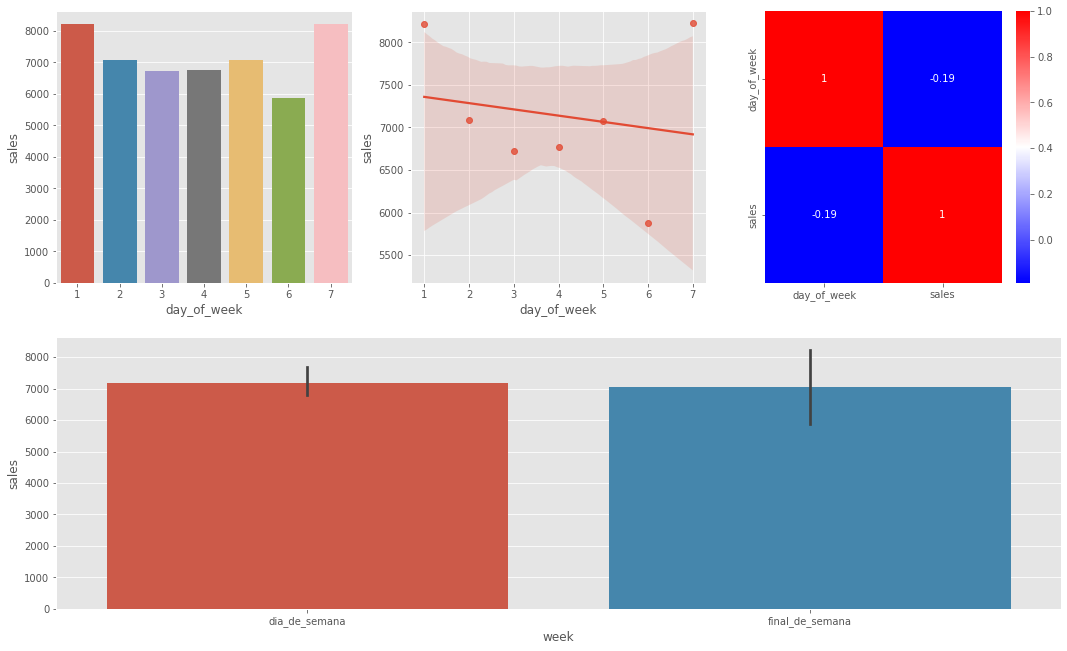

In [41]:
aux = df5.groupby('day_of_week', as_index=False)['sales'].mean()
# Os valores começam na segunda, ou seja, segunda é 1 e domingo é 7
aux['week'] = np.where(aux['day_of_week'] >= 6, 'final_de_semana', 'dia_de_semana')

grid = plt.GridSpec(2, 3)
plt.figure(figsize=(18, 11))

plt.subplot(grid[0, 0])
sns.barplot(x='day_of_week', y='sales', data=aux)

plt.subplot(grid[0, 1])
sns.regplot(x='day_of_week', y='sales', data=aux)

plt.subplot(grid[0, 2])
sns.heatmap(aux.corr(), annot=True, cmap='bwr');

aux1 = aux.groupby('week', as_index=False)['sales'].mean()

plt.subplot(grid[1, :])
sns.barplot(x='week', y='sales', data=aux);

### hipótese 11. Lojas deveriam vender menos durante os feriados escolares.
**Falsa**, pois as lojas vendem levemente a mais nos feriados escolares

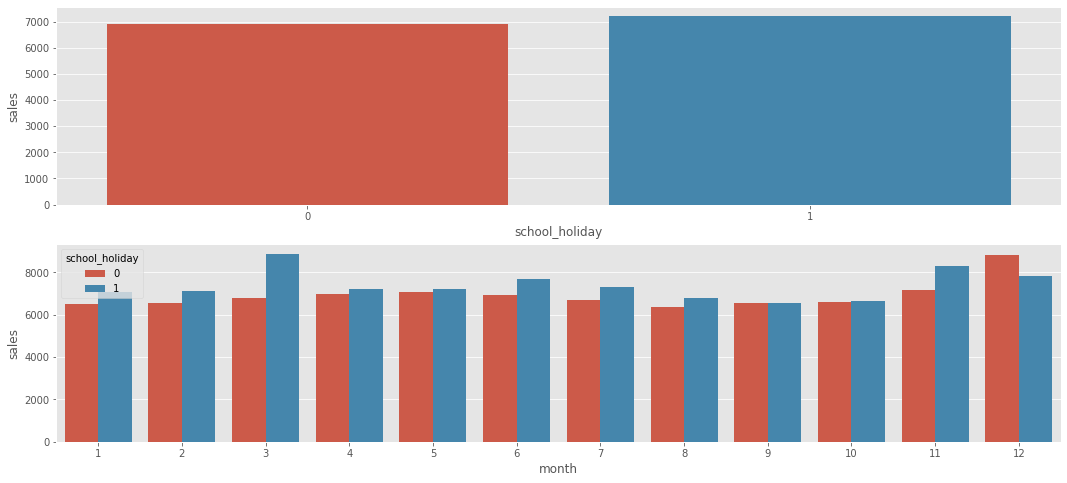

In [42]:
aux = df5.groupby('school_holiday', as_index=False)['sales'].mean()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux)

aux1 = df4.groupby(['month', 'school_holiday'], as_index=False)['sales'].mean()

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', data=aux1, hue='school_holiday');

## 5.3 - Resumo das hipóteses

In [43]:
df5[df5['school_holiday'] == 1]

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-31,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-31,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-31,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-31,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-31,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,2013,1,1,1,2013-01,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,2013,1,1,1,2013-01,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-01,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,2013,1,1,1,2013-01,2013-01-01,0,2012-12-31,0


In [44]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Verdadeira', 'Baixa'],
['H2', 'Falsa', 'Alta'],
['H3', 'Falsa', 'Média'],
['H4', 'Verdadeira', 'Baixa'],
['H5', 'Falsa', 'Média'],
['H6', 'Falsa', 'Média'],
['H7', 'Verdadeira', 'Baixa'],
['H8', 'Verdadeira', 'Média'],
['H9', 'Falsa', 'Média'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Falsa', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Alta
H3           Falsa        Média
H4           Verdadeira   Baixa
H5           Falsa        Média
H6           Falsa        Média
H7           Verdadeira   Baixa
H8           Verdadeira   Média
H9           Falsa        Média
H10          Verdadeira   Alta
H11          Falsa        Baixa


## 5.3 - Análise multivariada

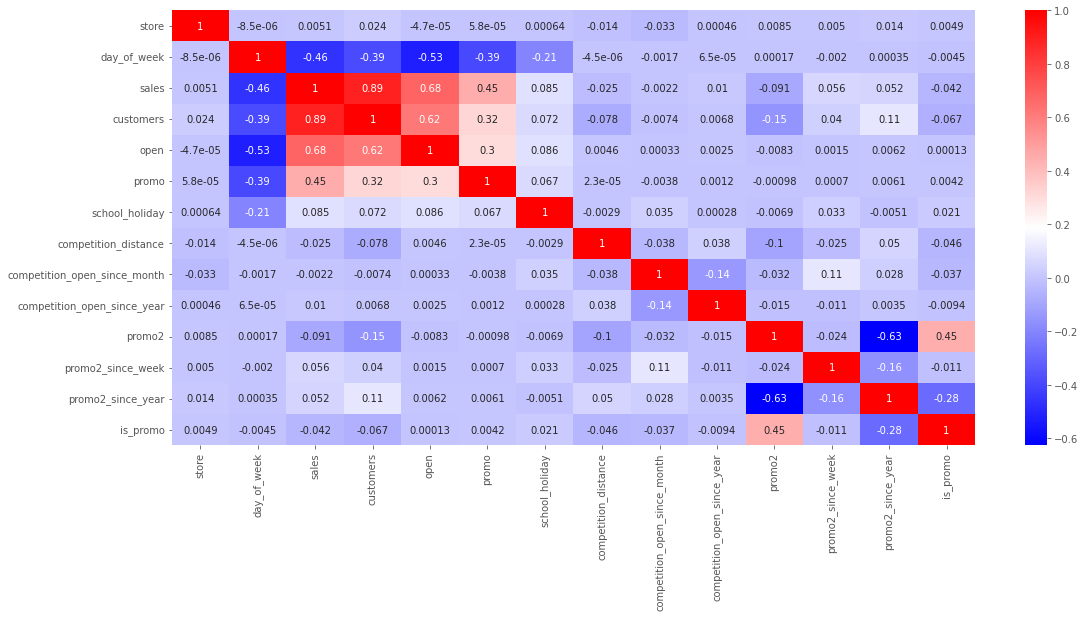

In [45]:
correlacao = num.corr()
sns.heatmap(correlacao, annot=True, cmap='bwr');

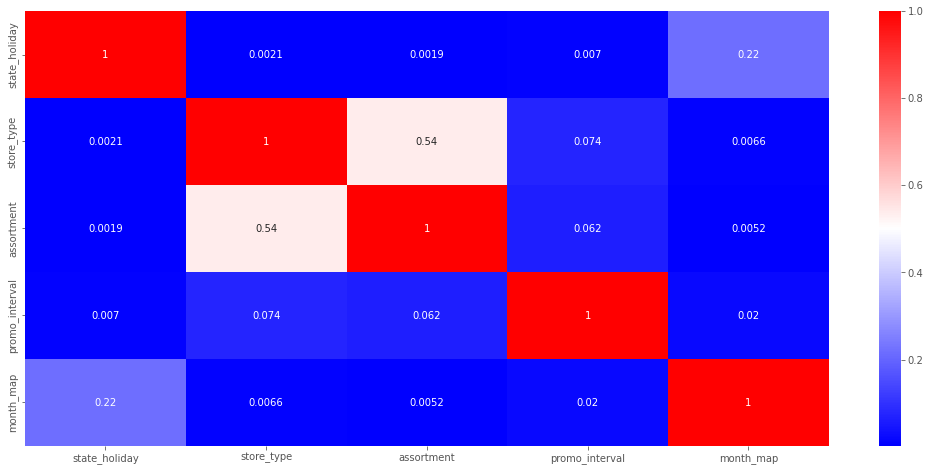

In [46]:
cat = cat.select_dtypes(include=['object'])
correlacao = corr_matrix(cat, cat.columns)
sns.heatmap(correlacao, annot=True, cmap='bwr');

# 6 - Preparação dos dados

In [47]:
df5 = df4.copy()

## 6.1 - Separação do dataset entre treino e teste

In [48]:
# Dataset de treino
X_train = df5[df5['date'] < '2015-06-19']
y_train = X_train['sales']
X_train.drop('sales', axis=1, inplace=True)

# Dataset de teste
X_test = df5[df5['date'] >= '2015-06-19']
y_test = X_test['sales']
X_test.drop('sales', axis=1, inplace=True)

print( 'Data mínima de treino: {}'.format( X_train['date'].min() ) )
print( 'Data mínima de treino: {}'.format( X_train['date'].max() ) )
print( '\nData mínima de teste: {}'.format( X_test['date'].min() ) )

Data mínima de treino: 2013-01-01 00:00:00
Data mínima de treino: 2015-06-18 00:00:00

Data mínima de teste: 2015-06-19 00:00:00


## 6.2 - Normalização

## 6.3 - Rescaling

In [49]:
rs_competition_distance = RobustScaler()
rs_competition_time_month = RobustScaler()
mms_promo_time_week = MinMaxScaler()
mms_year = MinMaxScaler()

###### DADOS DE TREINO ######
# competition distance
X_train['competition_distance'] = rs_competition_distance.fit_transform(X_train[['competition_distance']].values)

# competition time month
X_train['competition_time_month'] = rs_competition_time_month.fit_transform(X_train[['competition_time_month']].values)

# promo time week
X_train['promo_time_week'] = mms_promo_time_week.fit_transform(X_train[['promo_time_week']].values)

# year
X_train['year'] = mms_year.fit_transform(X_train[['year']].values)

###### DADOS DE TESTE ######
# competition distance
X_test['competition_distance'] = rs_competition_distance.transform(X_test[['competition_distance']].values)

# competition time month
X_test['competition_time_month'] = rs_competition_time_month.transform(X_test[['competition_time_month']].values)

# promo time week
X_test['promo_time_week'] = mms_promo_time_week.transform(X_test[['promo_time_week']].values)

# year
X_test['year'] = mms_year.transform(X_test[['year']].values)

In [118]:
joblib.dump(rs_competition_distance, 'modelo/rs_competition_distance.joblib')
joblib.dump(rs_competition_time_month, 'modelo/rs_competition_time_month.joblib')
joblib.dump(mms_promo_time_week, 'modelo/mms_promo_time_week')
joblib.dump(mms_year, 'modelo/mms_year')

['modelo/mms_year']

## 6.3 - Transformação

### 6.3.1 - Encoding

In [50]:
le = LabelEncoder()

###### DADOS DE TREINO ######
# story_type - Label Encoding
X_train['store_type'] = le.fit_transform(X_train['store_type'])

# assortment - Ordinal Encoding
assortment = {'basic':1, 'extra':2, 'extended':3}
X_train['assortment'] = X_train['assortment'].map(assortment)

# state_holiday - One Hot Encoding
X_train = pd.get_dummies(X_train, prefix=['state_holiday'], columns=['state_holiday'])


###### DADOS DE TESTE ######
# story_type - Label Encoding
X_test['store_type'] = le.transform(X_test['store_type'])

# assortment - Ordinal Encoding
assortment = {'basic':1, 'extra':2, 'extended':3}
X_test['assortment'] = X_test['assortment'].map(assortment)

# state_holiday - One Hot Encoding
X_test = pd.get_dummies(X_test, prefix=['state_holiday'], columns=['state_holiday'])

In [119]:
joblib.dump(le, 'modelo/le_sotry_type')

['modelo/le_sotry_type']

### 6.3.2 - Transformação da variável resposta

In [51]:
y_train = np.cbrt(y_train)
y_test = np.cbrt(y_test)

### 6.3.3 - Transformação de natureza

In [52]:
###### DADOS DE TREINO ######
# day of week
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month
X_train['month_sin'] = X_train['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
X_train['month_cos'] = X_train['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day
X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week of year
X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x * (2 *np.pi / 52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x * (2 *np.pi / 52)))


###### DADOS DE TESTE ######
X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month
X_test['month_sin'] = X_test['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
X_test['month_cos'] = X_test['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day
X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week of year
X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x * (2 *np.pi / 52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x * (2 *np.pi / 52)))

# 7 - Seleção de features

## 7.1 - Excluir colunas para a seleção

In [53]:
###### DADOS DE TREINO ######
X_train.drop(['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week'], axis=1, inplace=True)

###### DADOS DE TESTE ######
X_test.drop(['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week'], axis=1, inplace=True)

## 7.2 - Seleção de features com o Boruta

In [54]:
# # Treino e teste no Boruta
# X_train_n = X_train.drop('date', axis=1).values
# y_train_n = y_train.values.ravel()

# # Definindo o RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # Definindo Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [55]:
# cols_selected = boruta.support_.tolist()

# # Melhores features
# X_train_fs = X_train.drop(['date'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Colunas não selecionadas
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

## 7.3 - Seleção manual das features

In [56]:
cols_selected_boruta = [
'store',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'promo',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos'
]

# Adicionando colunas
aux = ['date']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(aux)

# 8 - Modelos de Machine Learning

In [57]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
df_full = X_train[cols_selected_boruta_full]
df_full['sales'] = y_train

## 8.1 - Average model (Baseline)

In [58]:
aux = x_test.copy()
aux['sales'] = y_test.copy()

# predição
aux2 = aux.groupby('store', as_index=False)['sales'].mean().rename(columns={'sales':'predictions'})
aux = pd.merge(aux, aux2, how='left', on='store')
y_pred_avg = aux['predictions']

# performance
resultado_avg = ml_error('Average Model', y_test ** 3, y_pred_avg ** 3)
resultado_avg

,model_name,MAE,MAPE,RMSE
0,Average Model,1357.61,20.95,1825.54


## 8.2 - Linear Regression

In [59]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

# predição
y_pred_lr = lr.predict(x_test)

# perfomance
resultado_lr = ml_error('Linear Regression Model', y_test ** 3, y_pred_lr ** 3)
np.round(resultado_lr, 2)

,model_name,MAE,MAPE,RMSE
0,Linear Regression Model,1876.86,30.12,2657.2


### 8.2.1 - Linear Regression com Cross Validation

In [60]:
lr = LinearRegression()
resultado_lr_cv = cross_validation(lr, 'Linear Regression', df_full, 5)
resultado_lr_cv

,model_name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,mean: 2082.92 | std: +/- 272.87,mean: 31.04 | std: +/- 1.96,mean: 2929.08 | std: +/- 443.46


## 8.3 - Linear Regression Regularized Model (Lasso)

In [61]:
# modelo
lrr = Lasso(alpha=0.01).fit(x_train, y_train)
# predição
y_pred_lrr = lrr.predict(x_test)
# perfomance
resultado_lrr = ml_error('Lasso', y_test ** 3, y_pred_lrr ** 3)
np.round(resultado_lrr, 2)

,model_name,MAE,MAPE,RMSE
0,Lasso,1872.71,29.29,2683.25


### 8.3.1 - Linear Regression Regularized Model (Lasso) com Cross Validation

In [62]:
lrr = Lasso(alpha=0.01)
resultado_lrr_cv = cross_validation(lrr, 'Lasso', df_full, 5)
resultado_lrr_cv

,model_name,MAE CV,MAPE CV,RMSE CV
0,Lasso,mean: 2078.82 | std: +/- 310.76,mean: 29.77 | std: +/- 1.27,mean: 2966.4 | std: +/- 479.19


## 8.4 - Random Forest Regressor

In [63]:
# # modelo
# rf = RandomForestRegressor(warm_start=True, n_estimators=100, n_jobs=1, random_state=42).fit(x_train, y_train)
# # predição
# y_pred_rf = rf.predict(x_test)
# # perfomance
# resultado_rf = ml_error('Random Forest Regressor', y_test ** 3, y_pred_rf ** 3)

### 8.4.1 - Random Forest Regressor com Cross Validation

In [64]:
# rf = RandomForestRegressor(warm_start=True, n_estimators=100, n_jobs=1, random_state=42)
# resultado_rf_cv = cross_validation(rf, 'Random Forest', df_full)
# resultado_rf_cv

## 8.5 - XGBoost Regressor

In [65]:
# modelo
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
n_estimators=100,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytee=0.9).fit(x_train, y_train)

# predição
y_pred_xgb = model_xgb.predict(x_test)

# performance
resultado_xgb = ml_error('XGBoost Regressor', y_test ** 3, y_pred_xgb ** 3)
np.round(resultado_xgb, 2)

,model_name,MAE,MAPE,RMSE
0,XGBoost Regressor,834.11,12.5,1202.28


### 8.5.1 - XGBoost Regressor com Cross Validation

In [66]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
n_estimators=100,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytee=0.9)

resultado_xgb_cv = cross_validation(model_xgb, 'XGBoost', df_full, 5, verbose=False)
resultado_xgb_cv

,model_name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,mean: 1030.79 | std: +/- 199.41,mean: 14.65 | std: +/- 2.26,mean: 1457.39 | std: +/- 266.99


## 8.6 - Comparando os resultados dos modelos

In [67]:
resultado = pd.concat([resultado_avg, resultado_lr, resultado_lrr, resultado_xgb])
resultado.sort_values('RMSE')

,model_name,MAE,MAPE,RMSE
0,XGBoost Regressor,834.11,12.50,1202.28
0,Average Model,1357.61,20.95,1825.54
0,Linear Regression Model,1876.86,30.12,2657.20
0,Lasso,1872.71,29.29,2683.25


### 8.6.1 - Comparando os modelos com cross validation

In [68]:
resultado_cv = pd.concat([resultado_lr_cv, resultado_lrr_cv, resultado_xgb_cv])
resultado_cv.sort_values('RMSE CV')

,model_name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,mean: 1030.79 | std: +/- 199.41,mean: 14.65 | std: +/- 2.26,mean: 1457.39 | std: +/- 266.99
0,Linear Regression,mean: 2082.92 | std: +/- 272.87,mean: 31.04 | std: +/- 1.96,mean: 2929.08 | std: +/- 443.46
0,Lasso,mean: 2078.82 | std: +/- 310.76,mean: 29.77 | std: +/- 1.27,mean: 2966.4 | std: +/- 479.19


In [69]:
resultado_cv.to_csv('dados/resultado_cv.csv', index=False)

# 9 - Fine Tunning

## 9.1 - Random Search

In [70]:
# param = {
# 'n_estimators': [100, 150, 170, 250, 325],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 10, 15],
# 'subsample': [0.1, 0.5, 0.7, 1],
# 'colsample_bytree': [0.3, 0.7, 0.9, 1],
# 'min_child_weight': [1, 3, 8, 15]
# }

# max_eval = 3

In [71]:
# resultado_final = pd.DataFrame()

# for i in range(max_eval):
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print(hp)

#     # modelo
#     xgb_model = xgb.XGBRegressor( objective='reg:squarederror',
#     n_estimators=hp['n_estimators'],
#     eta=hp['eta'],
#     max_depth=hp['max_depth'],
#     subsample=hp['subsample'],
#     colsample_bytree=hp['colsample_bytree'],
#     min_child_weight=hp['min_child_weight'] )

#     # perfomance
#     resultado_xgb_cv = cross_validation(xgb_model, 'XGBoost', df_full, 3, verbose=False)
#     resultado_xgb_cv
#     resultado_final = pd.concat( [resultado_final, resultado_xgb_cv] )
    
# resultado_final

## 9.2 - Modelo final

In [72]:
param_tuned = {
'n_estimators': 3000,
'eta': 0.03,
'max_depth': 5,
'subsample': 0.7,
'colsample_bytree': 0.7,
'min_child_weight': 3
}

In [73]:
# modelo
xgb_model_tunned = xgb.XGBRegressor(objective='reg:squarederror',
n_estimators=param_tuned['n_estimators'],
eta=param_tuned['eta'],
max_depth=param_tuned['max_depth'],
subsample=param_tuned['subsample'],
colsample_bytee=param_tuned['colsample_bytree'],
min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# predição
y_pred_xgb_tunned = xgb_model_tunned.predict(x_test)

# perfomance
resultado_xgb_tunned = ml_error('XGBost Regressor', y_test ** 3, y_pred_xgb_tunned ** 3)
resultado_xgb_tunned

,model_name,MAE,MAPE,RMSE
0,XGBost Regressor,652.35,9.74,935.34


In [74]:
joblib.dump(xgb_model_tunned, 'modelo/xgb_model_tunned.joblib')

['modelo/xgb_model_tunned.joblib']

# 10 - Tradução e interpretação do erro

In [87]:
df10 = X_test[cols_selected_boruta_full]
df10['sales'] = y_test
xgb_model_tunned = joblib.load('modelo/xgb_model_tunned.joblib')

# rescale
df10['sales'] = df10['sales'] ** 3
df10['predictions'] = xgb_model_tunned.predict(x_test) ** 3

## 10.1 - Business Perfomance

In [107]:
 # Soma das predições
df_aux = df10.groupby('store', as_index=False)['predictions'].sum()

# MAE e MAPE
df_aux2 = df10.groupby('store', as_index=False).apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).rename(columns={None: 'MAE'})

df_aux3 = df10.groupby('store', as_index=False).apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions']) * 100).rename(columns={None:'MAPE'})

df_aux4 = pd.merge(df_aux2, df_aux3, how='inner', on='store')
df_final = pd.merge(df_aux, df_aux4, how='inner', on='store')

# Cenários
df_final['pior_cenario'] = df_final['predictions'] - df_final['MAE']
df_final['melhor_cenario'] = df_final['predictions'] + df_final['MAE']
df_final = df_final[['store', 'predictions', 'pior_cenario', 'melhor_cenario', 'MAE', 'MAPE']]

In [111]:
 df_final.sort_values('MAPE', ascending=False).head(10)

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
291,292,105286.421875,101965.634059,108607.209691,3320.787816,57.100317
908,909,238229.390625,230726.742081,245732.039169,7502.648544,50.584637
875,876,205607.828125,201675.417374,209540.238876,3932.410751,31.316643
721,722,352294.593750,350321.658863,354267.528637,1972.934887,26.716227
781,782,221088.890625,220319.517143,221858.264107,769.373482,22.978772
273,274,198389.453125,197108.103402,199670.802848,1281.349723,22.223698
533,534,286046.031250,284680.039353,287412.023147,1365.991897,21.682954
1013,1014,424060.031250,422328.879843,425791.182657,1731.151407,21.363259
674,675,148232.062500,147520.531600,148943.593400,711.530900,20.723635
574,575,194891.546875,194001.991251,195781.102499,889.555624,19.612830


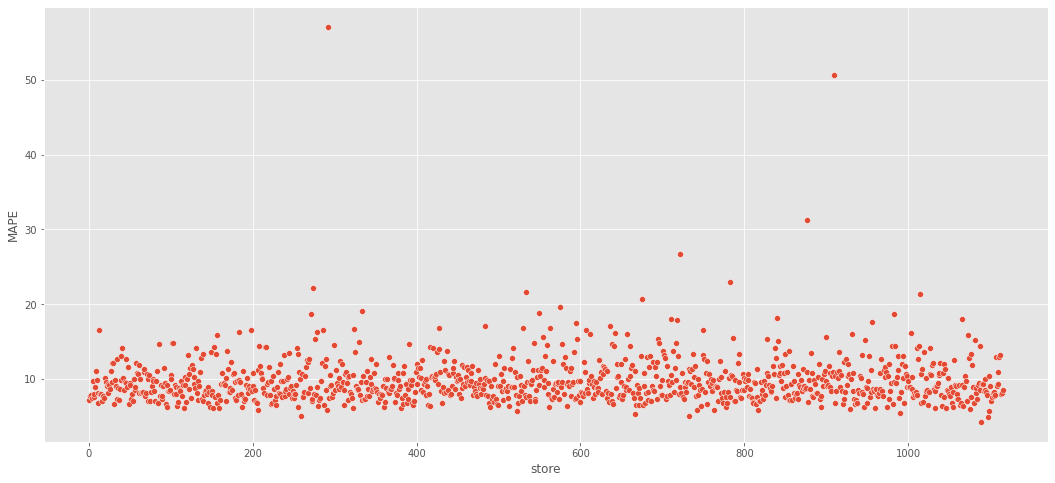

In [113]:
sns.scatterplot(x='store', y='MAPE', data=df_final);

## 10.2 - Total Perfomance

In [114]:
df_total = df_final[['predictions', 'melhor_cenario', 'pior_cenario']].sum().reset_index().rename(columns={'index':'cenario', 0:'valores'})

df_total['valores'] = df_total['valores'].map('R$ {:,.2f}'.format)
df_total

,cenario,valores
0,predictions,"R$ 288,081,024.00"
1,melhor_cenario,"R$ 288,812,366.33"
2,pior_cenario,"R$ 287,349,646.59"


## 10.3 - Machine Learning Perfomance

In [115]:
df10['error'] = df10['sales'] - df10['predictions']
df10['error_rate'] = df10['predictions'] / df10['sales']

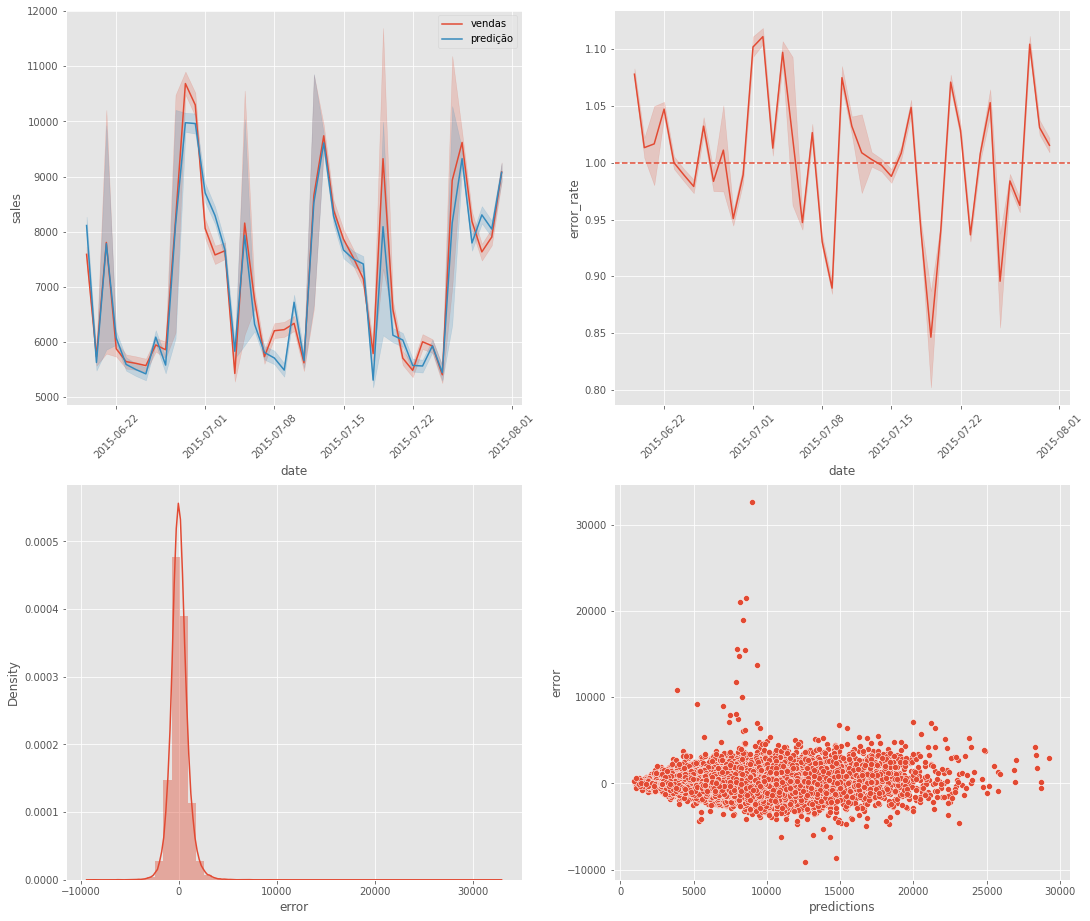

In [117]:
plt.figure(figsize=(18, 16))

plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df10, label='vendas')
sns.lineplot(x='date', y='predictions', data=df10, label='predição')
plt.xticks(rotation=45)

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df10)
plt.axhline(1, linestyle='--')
plt.xticks(rotation=45)

plt.subplot(2,2,3)
sns.distplot(df10['error'])

plt.subplot(2,2,4)
sns.scatterplot(x='predictions', y='error', data=df10);